In [136]:
using ModelingToolkit
using OrdinaryDiffEq
using DifferentialEquations
using AlgebraicPetri
using AlgebraicPetri.Epidemiology
using AlgebraicPetri.BilayerNetworks

using Plots
using Random

using Catlab
using Catlab.CategoricalAlgebra
using Catlab.Graphics
import Catlab.CategoricalAlgebra: migrate!
using Catlab.WiringDiagrams
using Catlab.Programs.RelationalPrograms

using JSON

In [11]:
make_depvar(p,t) = :($p($t))

make_depvar (generic function with 1 method)

In [12]:
function compile(bn::Union{AbstractLabelledBilayerNetwork, AbstractBilayerNetwork})
  varstmt = :(@variables t)
  varnames = bn[:variable]
  append!(varstmt.args, make_depvar.(bn[:variable], :t))

  paramstmt = :(@parameters)
  params = bn[:parameter]
  append!(paramstmt.args, bn[:parameter])

  diffstmt = :(D = Differential(t))

  ϕs = map(parts(bn, :Box)) do b
    vars = map(incident(bn, b,:call)) do i
      j = bn[i, :arg]
      return bn[j, :variable]
    end
    p = :(*($(bn[b, :parameter])))
    append!(p.args, vars)
    return :($(Symbol("ϕ$b")) = $p)
  end

  infs = map(parts(bn, :Qout)) do tv
    vars = map(incident(bn, tv, :infusion)) do wa
      j = bn[wa, :influx]
      return Symbol("ϕ$j")
    end
    p = :(+())
    append!(p.args, vars)

    # same for the outfluxes
    vars = map(incident(bn, tv, :effusion)) do wn
      j = bn[wn, :efflux]
      return :(- $(Symbol("ϕ$j")))
    end
    append!(p.args, vars)
    return p
  end

  zparts = zip(bn[:tanvar], infs)

  eqns = [:(D($tanvar) ~ $rhs) for (tanvar, rhs) in zparts]
  eq = :([])
  append!(eq.args, eqns)
  eqnstmt = :(eqs = $eq)

  varnameexpr = Expr(:tuple, varnames...)
  parnameexpr = Expr(:tuple, params...)

  return quote
    $varstmt
    $paramstmt
    $diffstmt
    $(ϕs...)
    $eqnstmt
    return $varnameexpr, $parnameexpr, ODESystem(eqs, t, name=:PetriNet)
  end
end

compile (generic function with 1 method)

In [13]:
@present TheoryOrigMIRANet <: SchLabelledReactionNet begin
    MID::AttrType
    MCTX::AttrType
    Template::AttrType
    mira_ids::Attr(S, MID)
    mira_context::Attr(S, MCTX)
    template_type::Attr(T, Template)
    parameter_name::Attr(T, Name)
    parameter_value::Attr(T, Rate)
end
@abstract_acset_type AbstractOrigMIRANet <: AbstractLabelledReactionNet
@acset_type OrigMIRANet(TheoryOrigMIRANet) <: AbstractOrigMIRANet

OrigMIRANet

In [24]:
function mtk_simulate(jsonfile, states, params, timespan)
    mira = read_json_acset(OrigMIRANet{Any,Any,Any,Any,Any,Any}, jsonfile)
    map!(Symbol, mira[:sname], mira[:sname])
    map!(Symbol, mira[:tname], mira[:tname])
    bnsir = LabelledBilayerNetwork()
    migrate!(bnsir, LabelledPetriNet(mira))
    mdl = eval(compile(bnsir))
    prob = ODEProblem(mdl[3], states, timespan, params)
    soln = solve(prob)
    return soln
end

mtk_simulate (generic function with 1 method)

In [137]:
soln = mtk_simulate("./thin-thread-examples/biomodels/BIOMD0000000971/model_petri.json", [1.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], rand(13), (0, 5))

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 16-element Vector{Float64}:
 0.0
 0.0062350572961397295
 0.05993172861123408
 0.16757880174989825
 0.3054968422332506
 0.48259714266592546
 0.7011340398928017
 0.9671493847542247
 1.2841228710088037
 1.6581168249739964
 2.094079267804356
 2.597080932588425
 3.1698683193318224
 3.809915251162884
 4.512237630810146
 5.0
u: 16-element Vector{Vector{Float64}}:
 [1.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.9999999989380662, 0.24836898847190683, 0.00024585942754787424, 0.0013841084637989838, 2.3550694673039663e-10, 3.4425129836648064e-7, 6.35465190790509e-7, 3.9878131853446253e-10]
 [0.9999991182329259, 0.2347561768708279, 0.0022259649454560867, 0.012925256486353513, 1.9497837256220829e-7, 3.0044671839506427e-5, 5.712757919461151e-5, 3.284475389928575e-7]
 [0.9999831313147777, 0.20967767881311575, 0.005520726030237929, 0.034133098966801764, 3.707342751663

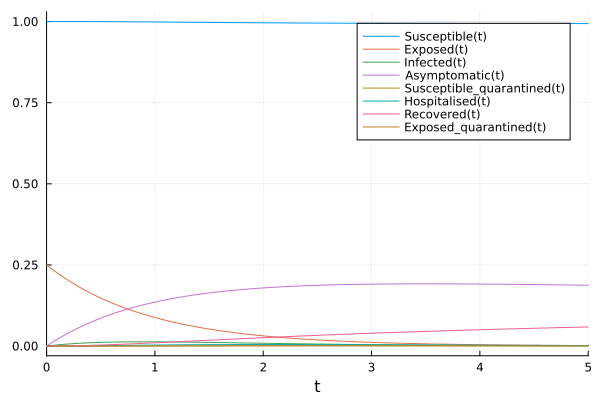

In [138]:
plot(soln)

In [27]:
JSON.json(Dict(:time=>soln.t, :states=>soln.u))

"{\"states\":[[0.08971249826544236,0.9775443223418805,0.5359020782605829,0.03908385826512428,0.22150751434402027,0.32146695601628617,0.7709882105475819,0.6703719547710204],[0.09325198191779507,0.9015546280269822,0.5256528504909306,0.07593979008993965,0.2178311791257098,0.33" ⋯ 682 bytes ⋯ "938657164118908,0.26441942976057403,0.28496002784370983,0.2777245264174306,0.17451634820930434,0.3856267661853079,1.3454461656434091,0.43550766644475464]],\"time\":[0.0,0.061815508684072526,0.20149385162152328,0.39306051680330256,0.6327787273978371,0.928397799982819,1.0]}"

In [139]:
model = JSON.parsefile("./thin-thread-examples/biomodels/BIOMD0000000971/model_petri.json")

Dict{String, Any} with 4 entries:
  "S" => Any[Dict{String, Any}("mira_context"=>"[]", "sname"=>"Susceptible", "m…
  "I" => Any[Dict{String, Any}("is"=>3, "it"=>1), Dict{String, Any}("is"=>4, "i…
  "T" => Any[Dict{String, Any}("tname"=>"t1", "parameter_name"=>"(('Susceptible…
  "O" => Any[Dict{String, Any}("ot"=>1, "os"=>3), Dict{String, Any}("ot"=>1, "o…

In [144]:
mira = read_json_acset(OrigMIRANet{Any,Any,Any,Any,Any,Any}, "./thin-thread-examples/biomodels/BIOMD0000000971/model_petri.json")

T,rate,tname,template_type,parameter_name,parameter_value
1,#undef,t1,GroupedControlledConversion,"(('Susceptible', ('identity', 'ido:0000514')), ('Exposed', ('identity', 'ido:0000514'), ('property', 'ido:0000597')), (('Infected', ('identity', 'ido:0000511')), ('Asymptomatic', ('identity', 'ido:0000511'))), 'GroupedControlledConversion', 'rate')",nothing
2,#undef,t2,GroupedControlledConversion,"(('Susceptible', ('identity', 'ido:0000514')), ('Susceptible_quarantined', ('identity', 'ido:0000514'), ('identity', 'ncit:C71902')), (('Infected', ('identity', 'ido:0000511')), ('Asymptomatic', ('identity', 'ido:0000511'))), 'GroupedControlledConversion', 'rate')",nothing
3,#undef,t3,NaturalConversion,lambda,0.0714285
4,#undef,t4,NaturalConversion,"(('Exposed', ('identity', 'ido:0000514'), ('property', 'ido:0000597')), ('Infected', ('identity', 'ido:0000511')), 'NaturalConversion', 'rate')",nothing
5,#undef,t5,NaturalConversion,"(('Exposed', ('identity', 'ido:0000514'), ('property', 'ido:0000597')), ('Asymptomatic', ('identity', 'ido:0000511')), 'NaturalConversion', 'rate')",nothing
6,#undef,t6,NaturalConversion,delta_I,0.13266
7,#undef,t7,NaturalConversion,gamma_I,0.33029
8,#undef,t8,NaturalConversion,gamma_A,0.13978
9,#undef,t9,NaturalConversion,gamma_H,0.11624
10,#undef,t10,NaturalDegradation,alpha,1.7826e-05


In [147]:
# Set RNG seed
Random.seed!(1234);

# Run simulation for every available model
for model_dir in readdir("./thin-thread-examples/biomodels", join = true)
    
    root, dirs, files = first(walkdir(model_dir))
    
    if "model_petri.json" in files
        
        jsonfile = joinpath(model_dir, "model_petri.json")
            
        # Set parameter and initial state values from `model` object
        # ?
        
        # Get number of parameters and states from `model` object and just generate random values
        model = JSON.parsefile(jsonfile)
        num_states = length(model["S"])
        num_params = length(model["T"])
        states = rand(num_states)
        params = rand(num_params)
        timespan = (0, 20)
        
        # Run simulation
        soln = mtk_simulate(jsonfile, states, params, timespan)
        
        # Serialize simulation output and write output to file
        data = Dict(:time=>soln.t, :states=>soln.u)
        open(joinpath(model_dir, "sim_output.json"), "w") do f
            JSON.print(f, data)
        end
        
        print("Success: $model_dir\n")
        
    else
        print("Error: missing `model_petri.json` in $model_dir\n")
    end
end

Success: ./thin-thread-examples/biomodels/BIOMD0000000955
Success: ./thin-thread-examples/biomodels/BIOMD0000000956
Success: ./thin-thread-examples/biomodels/BIOMD0000000957
Success: ./thin-thread-examples/biomodels/BIOMD0000000958
Success: ./thin-thread-examples/biomodels/BIOMD0000000960
Success: ./thin-thread-examples/biomodels/BIOMD0000000962
Success: ./thin-thread-examples/biomodels/BIOMD0000000963
Success: ./thin-thread-examples/biomodels/BIOMD0000000964
Success: ./thin-thread-examples/biomodels/BIOMD0000000969
Success: ./thin-thread-examples/biomodels/BIOMD0000000970
Success: ./thin-thread-examples/biomodels/BIOMD0000000971
Success: ./thin-thread-examples/biomodels/BIOMD0000000972
Success: ./thin-thread-examples/biomodels/BIOMD0000000974
Success: ./thin-thread-examples/biomodels/BIOMD0000000976
Success: ./thin-thread-examples/biomodels/BIOMD0000000977
Success: ./thin-thread-examples/biomodels/BIOMD0000000978
Success: ./thin-thread-examples/biomodels/BIOMD0000000979
Success: ./thi

LoadError: MethodError: no method matching *(::ComposedFunction{Num, Differential}, ::Num)
[0mClosest candidates are:
[0m  *(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m) at /opt/julia-1.7.3/share/julia/base/operators.jl:655
[0m  *([91m::StridedArray{P}[39m, ::Real) where P<:Dates.Period at /opt/julia-1.7.3/share/julia/stdlib/v1.7/Dates/src/deprecated.jl:44
[0m  *([91m::Union{SparseArrays.SparseVector{Tv, Ti}, SubArray{Tv, 1, <:SparseArrays.AbstractSparseMatrixCSC{Tv, Ti}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, false}, SubArray{Tv, 1, <:SparseArrays.AbstractSparseVector{Tv, Ti}, Tuple{Base.Slice{Base.OneTo{Int64}}}, false}} where {Tv, Ti}[39m, ::Number) at /opt/julia-1.7.3/share/julia/stdlib/v1.7/SparseArrays/src/sparsevector.jl:1474
[0m  ...